# Topic 1 A - PCA Foundations (variance, scree plot, 2D embedding)

In this notebook the **goal** is to understand PCA as a *representation change*:
- why we scale
- what “explained variance” means
- how to choose `n_components`
- how to interpret PCs (scores + loadings)

We use the built-in **Wine** dataset from scikit-learn.

# Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.datasets import load_wine

## 1) Load Data

In [20]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name="target")

print("Shape:", X.shape)
X.head()

Shape: (178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


## 2) Standardize

### Why `StandardScaler`?


📌 Official documentation:
- [StandardScaler (scikit-learn)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

PCA is based on **variance** (how much each feature “spreads out”).
If features are measured in different units/scales, the feature with the largest scale will usually have the largest variance and will **dominate PCA**.

Example:
- `alcohol` is around ~10–15
- `proline` can be in the hundreds/thousands

Without scaling, PCA will mainly align its first component with the **largest-scale feature**, not necessarily the most “informative” structure.

`StandardScaler` fixes this by converting each feature to **z-scores**:

$$
z = \frac{x - \mu}{\sigma}
$$

Where (for one feature/column):
- **x** = an original feature value (one number from your dataset)
- **μ (mu)** = the mean (average) of that feature across all samples
- **σ (sigma)** = the standard deviation of that feature across all samples (a measure of spread)

So after scaling:
- each feature has mean ≈ **0**
- each feature has standard deviation ≈ **1**
- PCA treats features more fairly (unit-free comparison)

> Important:
> - StandardScaler does **not** remove correlations. It only puts features on the same scale so PCA can “decide” directions based on relationships, not units.
> - We **standardize before PCA** because **PCA maximizes variance**, and **variance depends on units** - scaling prevents large-unit features from dominating the principal components.

In [22]:
# StandardScaler learns per-feature mean (mu) and std (sigma) from X,
# then transforms X into z-scores: (X - mu) / sigma

scaler = StandardScaler()

# fit_transform = fit + transform in one call:
# - fit: compute mu and sigma for each column (feature)
# - transform: apply (X - mu) / sigma using those learned values
X_scaled = scaler.fit_transform(X)

# sanity check: mean ~0, std ~1 (approximately)
print("Mean (first 5 features):", X_scaled.mean(axis=0)[:5].round(3))
print("Std  (first 5 features):", X_scaled.std(axis=0)[:5].round(3))


Mean (first 5 features): [ 0.  0. -0. -0. -0.]
Std  (first 5 features): [1. 1. 1. 1. 1.]


## 3) PCA to 2 components (visual intuition)

📌 Official documentation:
- [PCA (scikit-learn)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

### What are we doing here?

We take the standardized feature matrix **X_scaled** (shape: `n_samples × n_features`) and transform it into a new dataset with only **2 features**:

- **PC1** = the direction (linear combination of original features) that captures the **maximum variance**
- **PC2** = the next direction that captures the **second most variance**, and is **orthogonal** (90°) to PC1

So after PCA:
- original space: many dimensions (e.g., 13 features for Wine)
- PCA space: **2 dimensions** (PC1 and PC2)

This is mainly done for:
- **visualization** (we can plot PC1 vs PC2)
- understanding whether classes separate naturally in low dimension

---

### What does `fit_transform` mean for PCA?

`pca2.fit_transform(X_scaled)` is equivalent to:

1) **fit(X_scaled)**
   - learns the principal component directions (PC vectors) from the data
   - internally: computes directions that maximize variance (via SVD/eigendecomposition)

2) **transform(X_scaled)**
   - projects every sample onto those learned directions
   - result: the “coordinates” of each sample in the PC basis (**scores**)

So `X_pca2` contains the PCA **scores**:
- column 0 = score on PC1
- column 1 = score on PC2

---

### What does the scatter plot show?

Each point = one wine sample, plotted by:
- x-axis: its PC1 score
- y-axis: its PC2 score

We color points by their true class label (`y`) to see if the classes are separable in 2D.

If you see clear clusters → PCA captured useful structure in 2 dimensions.
If everything overlaps → either the structure needs more dimensions, or it’s nonlinear.

---

### What is `explained_variance_ratio_`?

`pca2.explained_variance_ratio_` tells you the fraction of total variance captured by each component:

- `explained_variance_ratio_[0]` = % variance explained by PC1
- `explained_variance_ratio_[1]` = % variance explained by PC2

The sum (PC1 + PC2) tells you:

> “How much of the original dataset’s information (in terms of variance) is preserved in this 2D view?”

So if the sum is, say, 0.55:
- the plot shows only ~55% of variance
- meaning: a lot of structure might live in higher dimensions

---

### Mini intuition check

- PCA components are **linear combinations** of original features (weighted sums)
- PC1/PC2 are **new axes**, not original features
- Two components = **2D snapshot** of a higher-dimensional world


### Fit PCA(2) + transform + shape check

In [32]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)


print("Original shape:", X_scaled.shape)
print("Reduced shape :", X_pca2.shape)

X_pca2

Original shape: (178, 13)
Reduced shape : (178, 2)


array([[ 3.31675081,  1.44346263],
       [ 2.20946492, -0.33339289],
       [ 2.51674015,  1.0311513 ],
       [ 3.75706561,  2.75637191],
       [ 1.00890849,  0.86983082],
       [ 3.05025392,  2.12240111],
       [ 2.44908967,  1.17485013],
       [ 2.05943687,  1.60896307],
       [ 2.5108743 ,  0.91807096],
       [ 2.75362819,  0.78943767],
       [ 3.47973668,  1.30233324],
       [ 1.7547529 ,  0.61197723],
       [ 2.11346234,  0.67570634],
       [ 3.45815682,  1.13062988],
       [ 4.31278391,  2.09597558],
       [ 2.3051882 ,  1.66255173],
       [ 2.17195527,  2.32730534],
       [ 1.89897118,  1.63136888],
       [ 3.54198508,  2.51834367],
       [ 2.0845222 ,  1.06113799],
       [ 3.12440254,  0.78689711],
       [ 1.08657007,  0.24174355],
       [ 2.53522408, -0.09184062],
       [ 1.64498834, -0.51627893],
       [ 1.76157587, -0.31714893],
       [ 0.9900791 ,  0.94066734],
       [ 1.77527763,  0.68617513],
       [ 1.23542396, -0.08980704],
       [ 2.18840633,

### Build a DataFrame for plotting

In [37]:
pca_df = pd.DataFrame(X_pca2, columns=["PC1", "PC2"])
pca_df["class"] = y

pca_df.head()

,PC1,PC2,class
0,3.316751,1.443463,0
1,2.209465,-0.333393,0
2,2.516740,1.031151,0
3,3.757066,2.756372,0
4,1.008908,0.869831,0


### Scatter plot PC1 vs PC2

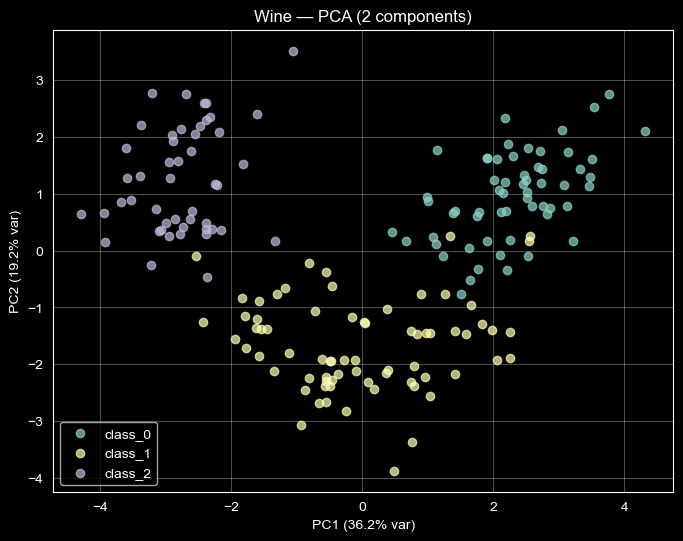

In [38]:
plt.figure(figsize=(8, 6))

for cls in sorted(pca_df["class"].unique()):
    subset = pca_df[pca_df["class"] == cls]
    plt.scatter(subset["PC1"], subset["PC2"], alpha=0.7, label=wine.target_names[cls])

plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Wine — PCA (2 components)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Print explained variance clearly

In [39]:
print("Explained variance ratio:")
print(f"  PC1: {pca2.explained_variance_ratio_[0]:.4f} ({pca2.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  PC2: {pca2.explained_variance_ratio_[1]:.4f} ({pca2.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Total (PC1 + PC2): {pca2.explained_variance_ratio_.sum():.4f} ({pca2.explained_variance_ratio_.sum()*100:.2f}%)")


Explained variance ratio:
  PC1: 0.3620 (36.20%)
  PC2: 0.1921 (19.21%)
  Total (PC1 + PC2): 0.5541 (55.41%)


### Loadings (top feature contributions to PC1 and PC2)

In [40]:
loadings = pd.DataFrame(
    pca2.components_.T,
    index=wine.feature_names,
    columns=["PC1_loading", "PC2_loading"]
)

print("Top contributors to PC1 (by absolute loading):")
display(loadings.reindex(loadings["PC1_loading"].abs().sort_values(ascending=False).index).head(8))

print("Top contributors to PC2 (by absolute loading):")
display(loadings.reindex(loadings["PC2_loading"].abs().sort_values(ascending=False).index).head(8))


Top contributors to PC1 (by absolute loading):


,PC1_loading,PC2_loading
flavanoids,0.422934,-0.003360
total_phenols,0.394661,0.065040
od280/od315_of_diluted_wines,0.376167,-0.164496
proanthocyanins,0.313429,0.039302
nonflavanoid_phenols,-0.298533,0.028779
hue,0.296715,-0.279235
proline,0.286752,0.364903
malic_acid,-0.245188,0.224931


Top contributors to PC2 (by absolute loading):


,PC1_loading,PC2_loading
color_intensity,-0.088617,0.529996
alcohol,0.144329,0.483652
proline,0.286752,0.364903
ash,-0.002051,0.316069
magnesium,0.141992,0.299634
hue,0.296715,-0.279235
malic_acid,-0.245188,0.224931
od280/od315_of_diluted_wines,0.376167,-0.164496


---

### ✅ Interpretation of results (Explained variance + meaning of PC1/PC2)

#### 1) Explained variance (how much of the dataset we “see” in 2D)
- **PC1 = 0.3620 (36.20%)**
- **PC2 = 0.1921 (19.21%)**
- **PC1 + PC2 = 0.5541 (55.41%)**

**Meaning:** the 2D PCA plot is a useful snapshot, but not the full story.
About **44.6%** of the variance still lives in the remaining components, so some structure/separation may appear only in higher PCs.

---

#### 2) What PC1 represents (dominant direction of variation)
Top contributors to **PC1** (absolute loadings):
- **flavanoids (+0.423)**
- **total_phenols (+0.395)**
- **od280/od315_of_diluted_wines (+0.376)**
- **proanthocyanins (+0.313)**
- **nonflavanoid_phenols (−0.299)**
- **hue (+0.297)**
- **proline (+0.287)**
- **malic_acid (−0.245)**

✅ **Interpretation:** PC1 is mainly a **phenolic composition / “wine chemistry richness”** axis.
- **Positive PC1**: higher flavanoids, total phenols, OD280/OD315, proanthocyanins
- **Negative PC1**: relatively higher nonflavanoid phenols and malic acid

---

#### 3) What PC2 represents (second dominant direction of variation)
Top contributors to **PC2** (absolute loadings):
- **color_intensity (+0.530)** (largest)
- **alcohol (+0.484)**
- **proline (+0.365)**
- **ash (+0.316)**
- **magnesium (+0.300)**
- **hue (−0.279)** (opposite direction)

✅ **Interpretation:** PC2 is mainly an **intensity / strength** axis.
- **Positive PC2**: higher color intensity, alcohol, proline, minerals
- **Negative PC2**: relatively higher hue (opposite direction)

---

#### 4) How to read signs (+ / −)
- **Absolute value** = strength of contribution
- **Sign** = which direction the feature pushes the PC score
- The **overall sign of a PC can flip** without changing the PCA meaning, so focus on the **relative contrasts**.

---

#### Exam-ready summary (1–2 lines)
- **PC1 (36.2%)** ≈ phenolic composition axis (flavanoids/phenols dominate).
- **PC2 (19.2%)** ≈ intensity/strength axis (color intensity + alcohol dominate).
- Together they explain **55.4%**, so the 2D plot is informative but incomplete.
